<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_III-Economic_Development/blob/main/Trablaho_Final_Big_Data_e_Setor_P%C3%BAblico_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Questão 1 - Biblioteca ipeadatapy e atualização statsmodel

In [115]:
# instalação ipeadatapy e atualização statsmodels

from IPython.display import clear_output

!pip uninstall statsmodels -y
!pip install statsmodels
!pip install ipeadatapy
!pip install pybacen
!pip install wbgapi
!pip install geopandas
!pip install mapclassify
!pip install geobr

clear_output() 

In [116]:
from google.colab import drive

drive.mount('/content/drive')

clear_output()

In [ ]:
# importação de bibliotecas necessárias

# manipulação de dados

import pandas as pd
import numpy as np

# estatística e modelos

from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 

# gráficos

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib as mpl
import seaborn as sns

# mapas

import geopandas as gpd
import mapclassify
import geobr

# estilo dos gráficos

from matplotlib import style
style.use("ggplot")

# coleta de dados
import ipeadatapy
from pybacen.bacen import time_series 
import wbgapi as wb

# web scraping
import requests
from bs4 import BeautifulSoup

## Questão 2 - Montando DataFrame com ipeadatapy

Professor, favor notar que está ocorrendo falha nas bibliotecas 'ipeadatapy' e 'dadosbr', de onde se supunha buscar os dados. Dado que a falha ocorre em diferentes bibliotecas que tentam buscar os dados no IPEAData, creio que seja alguma modificação recente, ao menos momentânea, na API do site. Dessa forma, busquei os dados em csv (o qual encaminho) para poder utilizá-los no excercício. Os desafios para utilização dos dados foram apenas diversos dos pretendidos para a atividade.

In [ ]:
# verificando a base de dados

ipeadatapy.describe('PAN12_IPCAG12')

,Índice de Preços ao Consumidor Ampliado (IPCA)
Name,Índice de Preços ao Consumidor Ampliado (IPCA)
Code,PAN12_IPCAG12
Big Theme,Macroeconômico
Theme,Sinopse macroeconômica
Source,Instituto Brasileiro de Geografia e Estatístic...
Source acronym,IBGE/SNIPC
Comment,Índice Nacional de Preços ao Consumidor Amplo ...
Last update,2022-01-12T08:30:01.28-03:00
Frequency,Mensal
Measure,(% a.a.)


In [117]:
# coletando taxa de inflação

dfIPCA = ipeadatapy.timeseries('PAN12_IPCAG12') 

dfIPCA

# conforme visto, tem sido apresentada inconsistência ao se solicitar a base de dados

ConnectionError: ignored

In [118]:
# tentando através de outro pacote

!pip install seriesbr

from seriesbr import ipea

clear_output()

In [119]:
ipea.get_series("PAN12_IPCAG12")

ConnectTimeout: ignored

In [120]:
# utilizando csv baixado através da página http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38391

dfIPCA = pd.read_csv("/content/drive/MyDrive/IDP/Dataset/PAN12_IPCAG12.CSV", sep=';', encoding='latin1')

In [121]:
dfIPCA

,Data,Índice de Preços ao Consumidor Ampliado (IPCA)
0,1980/01,115.70
1,1980/02,71.88
2,1980/03,102.10
3,1980/04,85.55
4,1980/05,94.55
...,...,...
499,2021/08,10.95
500,2021/09,14.84
501,2021/10,16.07
502,2021/11,12.02


In [122]:
# renomeando a coluna IPCA

dfIPCA.rename(columns={'Índice de Preços ao Consumidor Ampliado (IPCA)': 'IPCA'}, inplace=True)

dfIPCA.tail(5)

,Data,IPCA
499,2021/08,10.95
500,2021/09,14.84
501,2021/10,16.07
502,2021/11,12.02
503,2021/12,9.12


In [123]:
# setando Data como index e transformando a coluna Data para o formato correto:

dfIPCA['Data'] = pd.to_datetime(dfIPCA.Data)

dfIPCA.set_index('Data', inplace=True)

dfIPCA.tail(5)

,IPCA
Data,
2021-08-01,10.95
2021-09-01,14.84
2021-10-01,16.07
2021-11-01,12.02
2021-12-01,9.12


In [124]:
# dividindo por 100 para deixar no formato numérico

dfIPCA['IPCA'] = dfIPCA['IPCA'] / 100

dfIPCA.tail(10)

,IPCA
Data,
2021-03-01,0.1175
2021-04-01,0.0378
2021-05-01,0.1043
2021-06-01,0.0655
2021-07-01,0.1215
2021-08-01,0.1095
2021-09-01,0.1484
2021-10-01,0.1607
2021-11-01,0.1202


In [125]:
# mensalizando o IPCA

dfIPCA['IPCA'] = (1 + dfIPCA['IPCA']) ** (1 / 12) - 1

In [126]:
# levando os valores novamente para percentuais

dfIPCA['IPCA'] = dfIPCA['IPCA'] * 100 

In [127]:
# conferindo Dataset:

dfIPCA.tail()

,IPCA
Data,
2021-08-01,0.869672
2021-09-01,1.159754
2021-10-01,1.249604
2021-11-01,0.950381
2021-12-01,0.729968


## Questão 3

In [128]:
# puxando a base de dados

dfDesemprego = pd.read_csv('/content/drive/MyDrive/IDP/Dataset/PAN12_TD12.csv', sep=';')

dfDesemprego

,Data,Desemprego
0,01/03/2002,12.9
1,01/04/2002,12.5
2,01/05/2002,11.9
3,01/06/2002,11.6
4,01/07/2002,11.9
...,...,...
154,01/01/2015,5.3
155,01/02/2015,5.9
156,01/03/2015,6.2
157,01/04/2015,6.4


In [129]:
# configurando a base de dados

dfDesemprego['Data'] = pd.to_datetime(dfDesemprego.Data)

dfDesemprego.set_index('Data', inplace=True)

dfDesemprego['Desemprego'] = dfDesemprego['Desemprego'] / 100

dfDesemprego.tail(5)

,Desemprego
Data,
2015-01-01,0.053
2015-01-02,0.059
2015-01-03,0.062
2015-01-04,0.064
2015-01-05,0.067


In [130]:
# criando df de taxa de desocupação

dfDesocupacao = pd.read_excel('/content/drive/MyDrive/IDP/Dataset/populacao_ocupada_taxa_desocupacao.xlsx', index_col=0)

dfDesocupacao.reset_index(level=0, inplace=True)

dfDesocupacao = dfDesocupacao[['taxa_desocupacao', 'data']]

dfDesocupacao.rename(columns={'taxa_desocupacao': 'Desocupacao', 'data': 'Data'}, inplace=True)

dfDesocupacao.set_index('Data', inplace=True)

dfDesocupacao.tail(5)

,Desocupacao
Data,
2021-04-01,0.147
2021-05-01,0.146
2021-06-01,0.141
2021-07-01,0.137
2021-08-01,0.132


## Questão 4

In [131]:
# criando dataset unificado

dfDados = dfIPCA.merge(dfDesemprego, how='left', on=['Data'])

dfDados = dfDados.merge(dfDesocupacao, how='left', on=['Data'])

dfDados.tail(5)

,IPCA,Desemprego,Desocupacao
Data,,,
2021-08-01,0.869672,NaN,0.132
2021-09-01,1.159754,NaN,NaN
2021-10-01,1.249604,NaN,NaN
2021-11-01,0.950381,NaN,NaN
2021-12-01,0.729968,NaN,NaN


## Questão 5

In [132]:
# criando coluna Taxa_Desemprego com np.where

dfDados['Taxa_Desemprego'] = np.where(dfDados['Desocupacao'] > 0, dfDados['Desocupacao'], dfDados['Desemprego'])

dfDados

,IPCA,Desemprego,Desocupacao,Taxa_Desemprego
Data,,,,
1980-01-01,6.615622,NaN,NaN,NaN
1980-02-01,4.616964,NaN,NaN,NaN
1980-03-01,6.038569,NaN,NaN,NaN
1980-04-01,5.286272,NaN,NaN,NaN
1980-05-01,5.702665,NaN,NaN,NaN
...,...,...,...,...
2021-08-01,0.869672,NaN,0.132,0.132
2021-09-01,1.159754,NaN,NaN,NaN
2021-10-01,1.249604,NaN,NaN,NaN


In [133]:
# contando os valores não-nulos de cada coluna

dfDados.count()

IPCA               504
Desemprego          13
Desocupacao        114
Taxa_Desemprego    124
dtype: int64

## Questão 6

In [134]:
# selecionando apenas as colunas IPCA e Taxa_Desemprego

dfDados = dfDados[['IPCA', 'Taxa_Desemprego']]

dfDados.tail()

,IPCA,Taxa_Desemprego
Data,,
2021-08-01,0.869672,0.132
2021-09-01,1.159754,NaN
2021-10-01,1.249604,NaN
2021-11-01,0.950381,NaN
2021-12-01,0.729968,NaN


In [135]:
# removendo as linhas que contêm np.nan values

dfDados.dropna(inplace=True)

dfDados.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,IPCA,Taxa_Desemprego
Data,,
2021-04-01,0.309671,0.147
2021-05-01,0.830191,0.146
2021-06-01,0.530102,0.141
2021-07-01,0.960139,0.137
2021-08-01,0.869672,0.132


In [136]:
dfDados

,IPCA,Taxa_Desemprego
Data,,
2003-01-01,2.250326,0.112
2004-01-01,0.759920,0.117
2005-01-01,0.579502,0.102
2006-01-01,0.589662,0.093
2007-01-01,0.440026,0.093
...,...,...
2021-04-01,0.309671,0.147
2021-05-01,0.830191,0.146
2021-06-01,0.530102,0.141


## Questão 7

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Taxa de Desemprego')

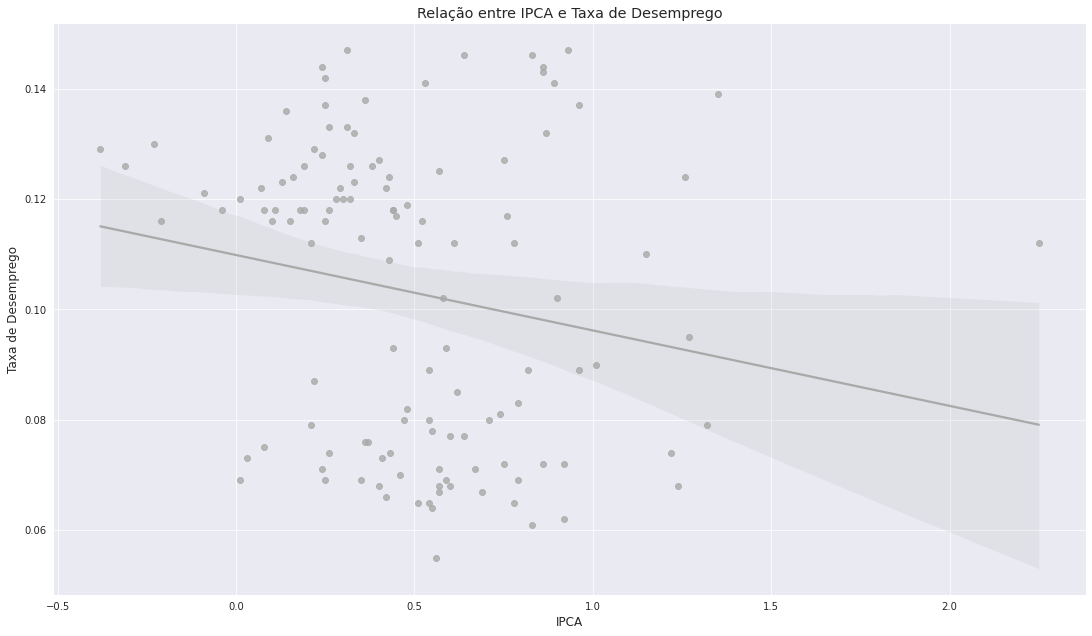

In [137]:
# Parece estar de acordo com o esperado, apresentando relação negativa entre as variáveis

sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(dfDados['IPCA'], dfDados['Taxa_Desemprego'], ax=ax, scatter_kws={"color": "darkgrey"}, line_kws={"color": "darkgrey"})

sns.despine()

plt.title('Relação entre IPCA e Taxa de Desemprego')
plt.xlabel('IPCA')
plt.ylabel('Taxa de Desemprego')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Taxa de Desemprego')

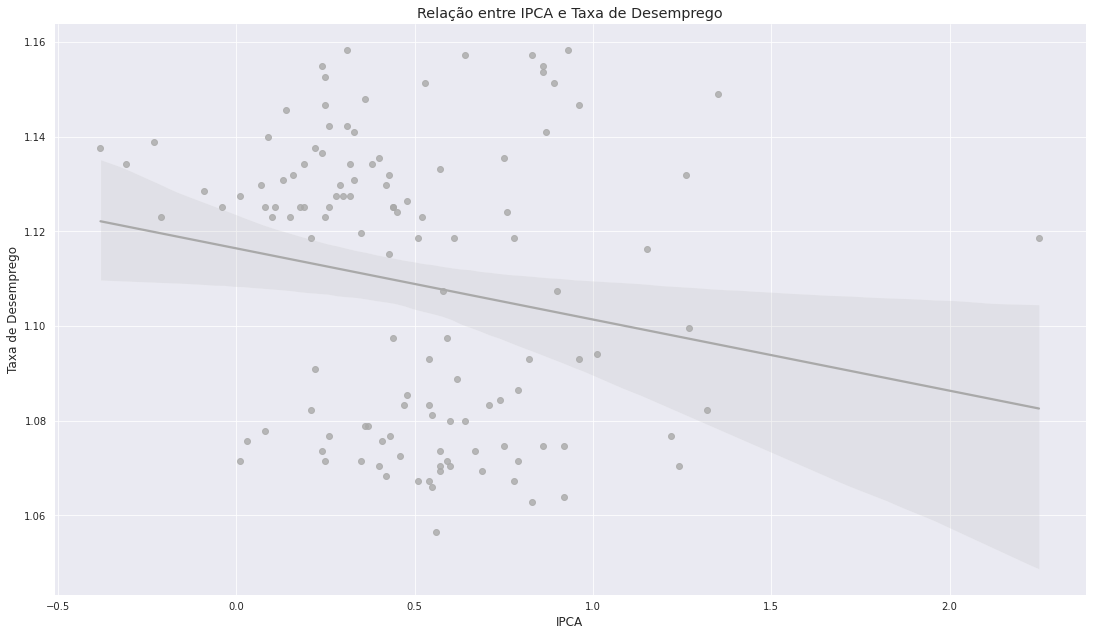

In [138]:
# avaliando a curva com a variável Taxa de Desemprego em termos absolutos (exponcenciada)

sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(dfDados['IPCA'], np.exp(dfDados['Taxa_Desemprego']), ax=ax, scatter_kws={"color": "darkgrey"}, line_kws={"color": "darkgrey"})

sns.despine()

plt.title('Relação entre IPCA e Taxa de Desemprego')
plt.xlabel('IPCA')
plt.ylabel('Taxa de Desemprego')

## Questão 8

In [139]:
# fazendo as diferenças das taxas de inflação e desemprego e retirando a linha com valores nulos

dfDados_diff = dfDados.diff().dropna()

In [140]:
# conferindo o dataframe das diferenças

dfDados_diff

,IPCA,Taxa_Desemprego
Data,,
2004-01-01,-1.490406,0.005
2005-01-01,-0.180419,-0.015
2006-01-01,0.010161,-0.009
2007-01-01,-0.149636,0.000
2008-01-01,0.100291,-0.013
...,...,...
2021-04-01,-0.620411,0.000
2021-05-01,0.520520,-0.001
2021-06-01,-0.300089,-0.005


In [141]:
# realizando o teste de estacionariedade para IPCA

resultado_IPCA = adfuller(dfDados_diff['IPCA'], autolag='AIC')

print(f"P-valor do teste: {resultado_IPCA[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# nesse caso, rejeita-se a hipótese nula e nota-se que a série IPCA é estacionária

P-valor do teste: 4.918002229201953e-10
H0: a série NÃO é estacionária e possui raiz unitária.


In [142]:
# realizando teste de estacionariedade para taxa de desemprego

resultado_desemprego = adfuller(dfDados_diff['Taxa_Desemprego'], autolag='AIC')

print(f"P-valor do teste: {resultado_desemprego[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# com p-value maior que 0.05, não se pode rejeitar a hipótese nula, os dados são não estacionários

P-valor do teste: 0.32902862240415454
H0: a série NÃO é estacionária e possui raiz unitária.


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


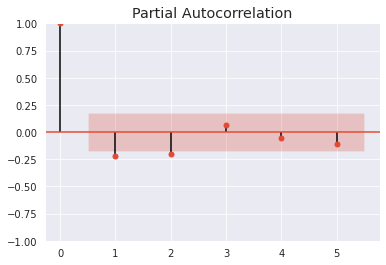

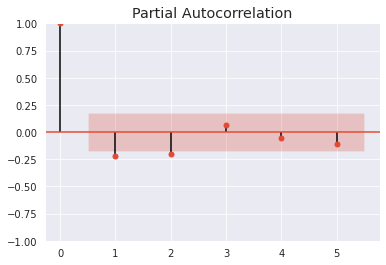

In [143]:
# autocorrelação parcial

plot_pacf(dfDados_diff['IPCA'], lags=5)

In [144]:
# fazendo modelo ARIMA

modelo_arima = ARIMA(endog=dfDados_diff['IPCA'],
                     exog=dfDados_diff['Taxa_Desemprego'],
                     order=(1, 0, 0)).fit()
## Vendo resultados
clear_output()
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   IPCA   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -41.251
Date:                Thu, 27 Jan 2022   AIC                             90.503
Time:                        19:22:33   BIC                            101.752
Sample:                             0   HQIC                            95.072
                                - 123                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0073      0.027     -0.268      0.789      -0.061       0.046
Taxa_Desemprego    -9.2957      7.843     -1.185      0.236     -24.669       6.077
ar.L1              -0.2343      

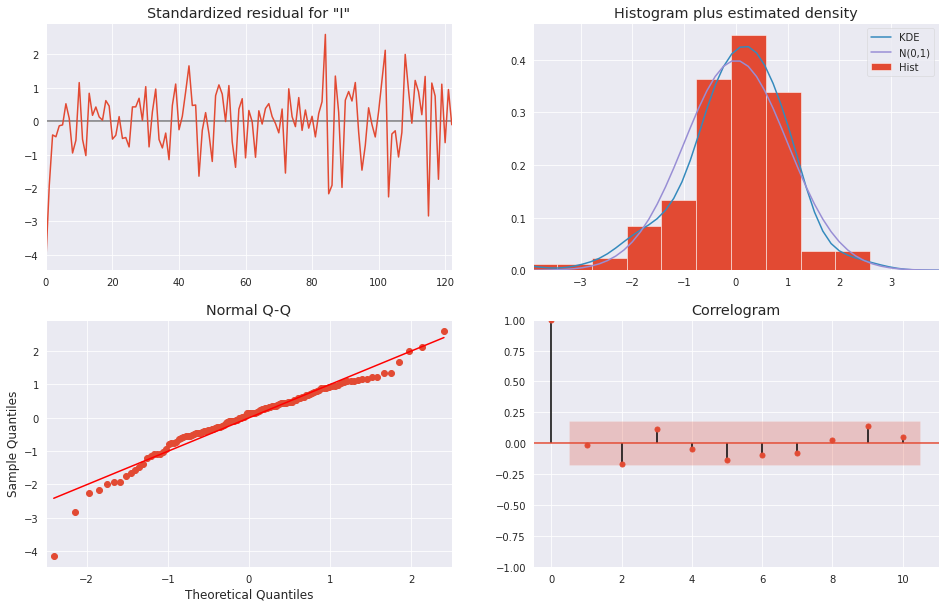

In [146]:
# diagnósticos

modelo_arima.plot_diagnostics(figsize=(16, 10))

plt.show()

In [ ]:
# de acordo com o sumário, não há heteroscedasticidade, pois a mesma não pode ser rejeitada

# Jarque-Bera indica que os dados são normais, já que p-value é muito maior que 0.05

# o resíduo da amostra não possui autocorrelação, o que somado à heteroscedasticidade indicam que há ruído branco